In [19]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler


In [20]:
training_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_0926.csv"
median_income_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv"


# Set up training Set

In [21]:
#parameters

max_bedrooms = 6
min_bedrooms = 0
max_bathrooms = 4
min_bathrooms = 0
max_sqft = 5000
max_rent = 10000

In [22]:
df = pd.read_csv(training_data_source)

df = df.rename(columns={
    'price': 'rent',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})

basic_metadata = ["property_id", "address", "city", "state"]
basic_features = ["square_feet", "bedrooms", "bathrooms"]
target = "rent"


for feature in basic_features + [target, "latitude", "longitude"]:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

df = df.drop_duplicates(subset='property_id')

print("Total Count of Homes before Cleaning",df["property_id"].count())

df = df[(df["bedrooms"] > min_bedrooms ) 
        & (df["bedrooms"] < max_bedrooms)  
        & (df["bathrooms"] < max_bathrooms)  
        & (df["state_code"].notna()) 
        & (df["property_type"] == "6") 
    ]

df = df.drop_duplicates(subset=["latitude", "longitude"])

#Get Median Income Data
median_income = pd.read_csv(median_income_data_source, skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]


df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["property_id"].count())

Total Count of Homes before Cleaning 45180
15397


In [23]:
# Generate the full range of possible values for bedrooms (increments of 1) and bathrooms (increments of 0.5)
bedroom_range = np.arange(min_bedrooms, max_bedrooms + 1, 1)
bathroom_range = np.arange(min_bathrooms, max_bathrooms + 0.5, 0.5)

# Initialize OneHotEncoder with the full range of categories
encoder = OneHotEncoder(sparse_output=False, drop='first', 
                        categories=[bedroom_range, bathroom_range])  # Explicit categories for bedrooms and bathrooms

# Fit and transform the data
encoded_features = encoder.fit_transform(df[['bedrooms', 'bathrooms']])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(['bedrooms', 'bathrooms'])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df_onehot = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()


# Basic KNN Features

In [24]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'df' is your DataFrame and it's already loaded
# Example:
# df = pd.read_csv('your_data.csv')

knn_features = ["latitude", "longitude"]
target = 'rent'

# List of different n values
n_values = [1, 5, 10]  # You can adjust these as needed
max_n = max(n_values)

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Drop rows with missing values in the knn_features or target columns
knn_df = df[knn_features + [target]].dropna()

# Extract feature values and target values
X = knn_df[knn_features].values
y = knn_df[target].values

# Convert latitude and longitude from degrees to radians for haversine metric
X_rad = np.radians(X)

# Initialize the KNeighborsRegressor with the haversine metric
# Set n_neighbors to max_n + 1 to account for excluding the point itself
knn = KNeighborsRegressor(n_neighbors=max_n *2, metric='haversine')

# Fit the KNN model
knn.fit(X_rad, y)

# Find the neighbors for each point in the original DataFrame
distances, indices = knn.kneighbors(df_rad)

# Initialize dictionaries to hold rent benchmarks and average distances
rent_benchmarks = {n: [] for n in n_values}
average_distances = {n: [] for n in n_values}

# Iterate over each point's neighbors
for i in range(len(df)):
    # Extract distances and indices for the current point
    current_distances = distances[i]
    current_indices = indices[i]
    
    # Filter out neighbors with distance = 0 (self)
    valid_mask = current_distances > 0
    valid_distances = current_distances[valid_mask]
    valid_indices = current_indices[valid_mask]
    
    # If you have missing values in y_full, ensure alignment
    # Create a mapping from knn_df's indices to y
    # Since knn_df is a subset of df, we need to map original indices
    # Assuming df's index aligns with y_full
    # Otherwise, adjust accordingly
    neighbor_rents = y[knn_df.index.get_indexer(valid_indices)]
    
    for n in n_values:
        if len(neighbor_rents) >= n:
            selected_rents = neighbor_rents[:n]
            selected_distances = valid_distances[:n]
        else:
            # Handle cases where fewer than n neighbors are available
            selected_rents = neighbor_rents
            selected_distances = valid_distances
        # Compute average rent
        avg_rent = selected_rents.mean() if len(selected_rents) > 0 else np.nan
        rent_benchmarks[n].append(avg_rent)
        
        # Compute average distance in kilometers (haversine distance is in radians)
        # Earth's radius ≈ 6371 km
        avg_distance_km = selected_distances.mean() * 6371 if len(selected_distances) > 0 else np.nan
        average_distances[n].append(avg_distance_km)

# Add the computed benchmarks and distances to the DataFrame
for n in n_values:
    df[f'Rent_Benchmark_{n}_neighbors'] = rent_benchmarks[n]
    df[f'Average_Distance_{n}_neighbors'] = average_distances[n]


# Same Beds KNN Features

In [25]:
bed_feature = 'bedrooms'

# Extract the bed feature values
bed_df = df[knn_features + [target, bed_feature]].dropna()

X_bed = bed_df[knn_features].values
y_bed = bed_df[target].values
beds = bed_df[bed_feature].values

# Convert latitude and longitude from degrees to radians for haversine metric
X_bed_rad = np.radians(X_bed)

# Fit the KNN model again using a larger neighbor count and filter by beds after
knn_beds = KNeighborsRegressor(n_neighbors=max_n * 2, metric='haversine')

# Fit the model
knn_beds.fit(X_bed_rad, y_bed)

# Find neighbors and distances
bed_distances, bed_indices = knn_beds.kneighbors(df_rad)

# Initialize dictionaries to hold rent benchmarks and distances filtered by beds
bed_rent_benchmarks = {n: [] for n in n_values}
bed_average_distances = {n: [] for n in n_values}

# Iterate over each point's neighbors and filter by number of beds
for i in range(len(df)):
    current_distances_bed = bed_distances[i]
    current_indices_bed = bed_indices[i]
    
    # Filter out neighbors with distance = 0 (self)
    valid_mask_bed = current_distances_bed > 0
    valid_distances_bed = current_distances_bed[valid_mask_bed]
    valid_indices_bed = current_indices_bed[valid_mask_bed]
    
    # Get the number of beds for the current property
    current_beds = df.loc[i, bed_feature]
    
    # Filter neighbors that have the same number of beds
    valid_beds_mask = beds[valid_indices_bed] == current_beds
    valid_distances_bed = valid_distances_bed[valid_beds_mask]
    valid_indices_bed = valid_indices_bed[valid_beds_mask]
    
    # Get the rent of the valid neighbors with the same number of beds
    neighbor_rents_bed = y_bed[valid_indices_bed]
    
    for n in n_values:
        if len(neighbor_rents_bed) >= n:
            selected_rents_bed = neighbor_rents_bed[:n]
            selected_distances_bed = valid_distances_bed[:n]
        else:
            # Handle cases where fewer than n neighbors are available
            selected_rents_bed = neighbor_rents_bed
            selected_distances_bed = valid_distances_bed
        
        # Compute average rent
        avg_rent_bed = selected_rents_bed.mean() if len(selected_rents_bed) > 0 else np.nan
        bed_rent_benchmarks[n].append(avg_rent_bed)
        
        # Compute average distance for beds
        avg_distance_km_bed = selected_distances_bed.mean() * 6371 if len(selected_distances_bed) > 0 else np.nan
        bed_average_distances[n].append(avg_distance_km_bed)

# Add the computed rent and distance by beds to the DataFrame
for n in n_values:
    df[f'Beds_Rent_Benchmark_{n}_neighbors'] = bed_rent_benchmarks[n]
    df[f'Beds_Average_Distance_{n}_neighbors'] = bed_average_distances[n]


In [26]:
benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]
bed_benchmark_features = [f'Beds_Rent_Benchmark_{n}_neighbors' for n in n_values]

# State and CBSA Features

In [27]:
def calculate_average_excluding_self(df, group_column, target_column):
    """
    This function calculates the average of `target_column` for each group in `group_column`,
    excluding the current row in the group to avoid data leakage.
    """
    group_sums = df.groupby(group_column)[target_column].transform('sum')
    group_counts = df.groupby(group_column)[target_column].transform('count')
    
    # Exclude the current row's rent from the sum and subtract 1 from the count
    df[f'{group_column}_average_rent'] = (group_sums - df[target_column]) / (group_counts - 1)
    
    return df

# Load your data (assuming df is already loaded)
# Example:
# df = pd.read_csv('single_family_home_rentals.csv')

# Calculate the average rent per CBSA excluding the current row
df = calculate_average_excluding_self(df, 'cbsa_geoid', 'rent')

# Calculate the average rent per State excluding the current row
df = calculate_average_excluding_self(df, 'state_code', 'rent')

df = calculate_average_excluding_self(df, 'state_code', 'rent')


# Display the first few rows to verify the results
display(df[['cbsa_geoid', 'state_code', 'rent', 'cbsa_geoid_average_rent', 'state_code_average_rent']].head())

,cbsa_geoid,state_code,rent,cbsa_geoid_average_rent,state_code_average_rent
0,42660,WA,2000.0,3301.097656,2882.638280
1,42660,WA,3100.0,3300.238281,2882.165161
2,42660,WA,3275.0,3300.101562,2882.089892
3,42660,WA,2995.0,3300.320312,2882.210323
4,42660,WA,2900.0,3300.394531,2882.251183


# Initial Model Training

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import xgboost as xgb

# List of features to use for prediction
features = ['square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
            'median_income', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', 'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', 'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', 'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# Drop rows with missing values in any of the features or target
df_clean = df[features + [target]].dropna()

# Split the data into training and testing sets
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models you want to train and evaluate
model = xgb.XGBRegressor(
        n_estimators=500, 
        colsample_bytree = 1.0,
        learning_rate = .1,
        max_depth =5,
        subsample = .8,
        random_state=42)

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', model)  # XGBoost model
])


# Function to train and evaluate the models

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mse}")
print(f"median absolute error {medae}")
print(f"R-squared: {r2}")

# Displaying first few actual vs predicted rent values
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(predictions.head(10))


Mean Absolute Error: 134.0095228810605
median absolute error 68.277099609375
R-squared: 0.8867616345845505


,Actual,Predicted
2773,1995.0,1946.644043
12427,1700.0,1879.731445
4606,1850.0,1855.770874
12386,1200.0,1270.471069
5807,1490.0,1412.592285
11160,1750.0,1582.693237
15321,1980.0,1899.356201
1093,1995.0,2036.545532
7196,2900.0,2824.114258
338,3850.0,3806.594727


# Feature Selection

In [47]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# List of features to use for prediction
features = ['square_feet', 'bedrooms', 'bathrooms', 
            'median_income', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', 'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', 'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', 'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# Drop rows with missing values in any of the features or target
df_clean = df[features + [target]].dropna()

# Split the data into training and testing sets
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base model for RFECV (XGBoost)
model = xgb.XGBRegressor(
        n_estimators=500, 
        colsample_bytree = 1.0,
        learning_rate = .1,
        max_depth =5,
        subsample = .8,
        random_state=42)

# Define the pipeline with scaling
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

# Scale the features
X_train_scaled = model_pipeline["scaler"].fit_transform(X_train)
X_test_scaled = model_pipeline["scaler"].transform(X_test)

# Apply RFECV with the XGBoost model
rfecv = RFECV(
    estimator=model, 
    step=1,  # Remove 1 feature at a time
    cv=KFold(5),  # Use 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Using MAE as the scoring metric
    n_jobs=-1  # Use all available processors
)

# Fit RFECV to the scaled data
rfecv.fit(X_train_scaled, y_train)

# Get the ranking of the features
ranking = rfecv.ranking_
selected_features = np.array(features)[ranking == 1]
print(f"Selected Features: {selected_features}")

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Predict on the test set using the selected features
y_pred_rfecv = rfecv.predict(X_test_scaled)

# Evaluate the model after RFECV
mse_rfecv = mean_absolute_error(y_test, y_pred_rfecv)
medae_rfecv = median_absolute_error(y_test, y_pred_rfecv)
r2_rfecv = r2_score(y_test, y_pred_rfecv)

print(f"Mean Absolute Error (RFECV): {mse_rfecv}")
print(f"Median Absolute Error (RFECV): {medae_rfecv}")
print(f"R-squared (RFECV): {r2_rfecv}")

# Display first few actual vs predicted rent values after RFECV
predictions_rfecv = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rfecv})
display(predictions_rfecv.head(10))


Selected Features: ['square_feet' 'bathrooms' 'Average_Distance_5_neighbors'
 'Beds_Rent_Benchmark_5_neighbors' 'Beds_Rent_Benchmark_10_neighbors'
 'cbsa_geoid_average_rent' 'state_code_average_rent']
Optimal number of features: 7
Mean Absolute Error (RFECV): 110.81207814511227
Median Absolute Error (RFECV): 51.20068359375
R-squared (RFECV): 0.8982282062509931


,Actual,Predicted
2773,1995.0,1991.349487
12427,1700.0,1895.074097
4606,1850.0,1816.842407
12386,1200.0,1164.990479
5807,1490.0,1461.661743
11160,1750.0,1738.982544
15321,1980.0,1926.646606
1093,1995.0,1968.638428
7196,2900.0,2957.895508
338,3850.0,3717.501953


# Fine Tuning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import xgboost as xgb

# Features selected from RFECV
selected_features = ['square_feet', 'bathrooms', 'Average_Distance_5_neighbors',
                     'Beds_Rent_Benchmark_5_neighbors', 'Beds_Rent_Benchmark_10_neighbors',
                     'cbsa_geoid_average_rent', 'state_code_average_rent']

# Subset the training data with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for fine-tuning
param_grid = {
    'n_estimators': [100, 500, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define the scoring metric (Mean Absolute Error in this case)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up cross-validation using 5-fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1)

# Fit the GridSearchCV to the selected features
grid_search.fit(X_train_selected, y_train)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Mean Absolute Error: {-grid_search.best_score_}")

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test_selected)

# Evaluate the model after tuning
mse_tuned = mean_absolute_error(y_test, y_pred_tuned)
medae_tuned = median_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Mean Absolute Error (Tuned): {mse_tuned}")
print(f"Median Absolute Error (Tuned): {medae_tuned}")
print(f"R-squared (Tuned): {r2_tuned}")

# Display the first few actual vs predicted rent values after fine-tuning
predictions_tuned = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tuned})
display(predictions_tuned.head(10))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'subsample': 1.0}
Best Mean Absolute Error: 128.9154063122693
Mean Absolute Error (Tuned): 111.23833362570616
Median Absolute Error (Tuned): 43.67236328125
R-squared (Tuned): 0.8877702954443583


,Actual,Predicted
2773,1995.0,1963.335083
12427,1700.0,1816.542480
4606,1850.0,1910.626587
12386,1200.0,1175.312988
5807,1490.0,1497.212280
11160,1750.0,1630.653809
15321,1980.0,1947.649292
1093,1995.0,1997.176147
7196,2900.0,2842.850098
338,3850.0,3932.869873


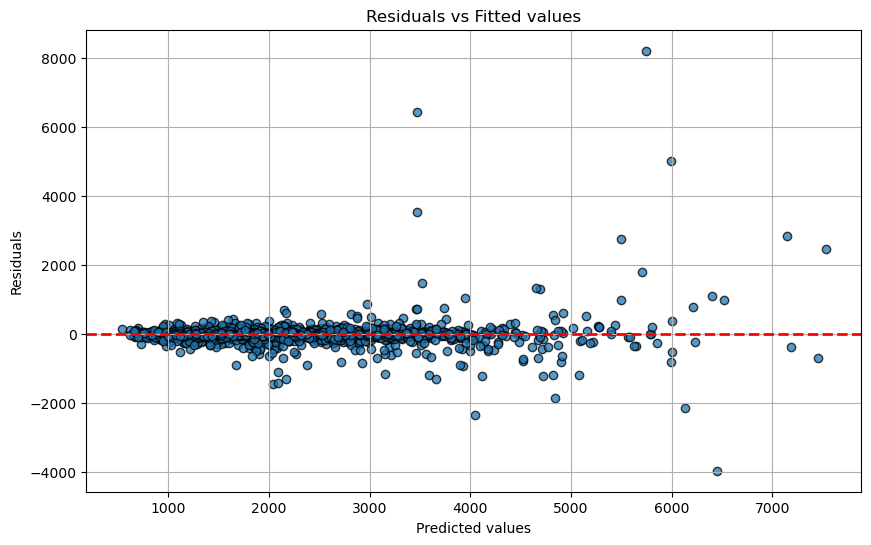

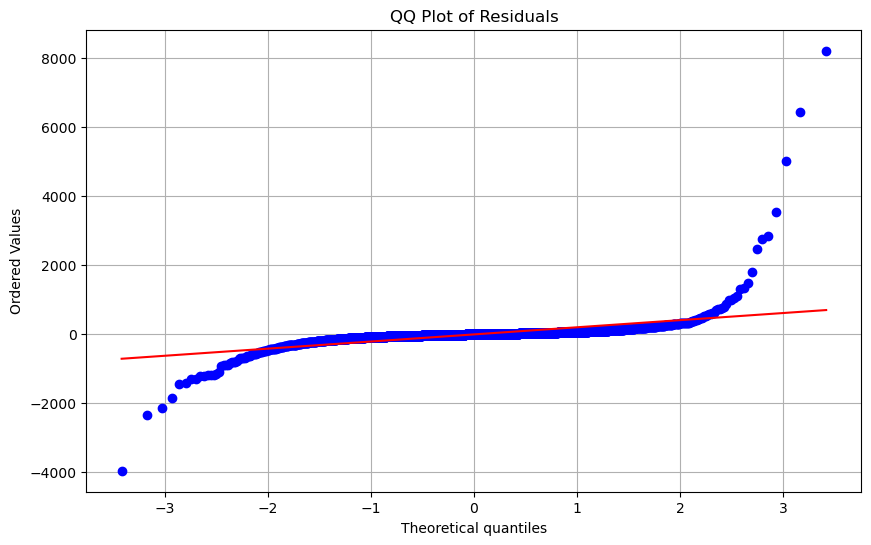

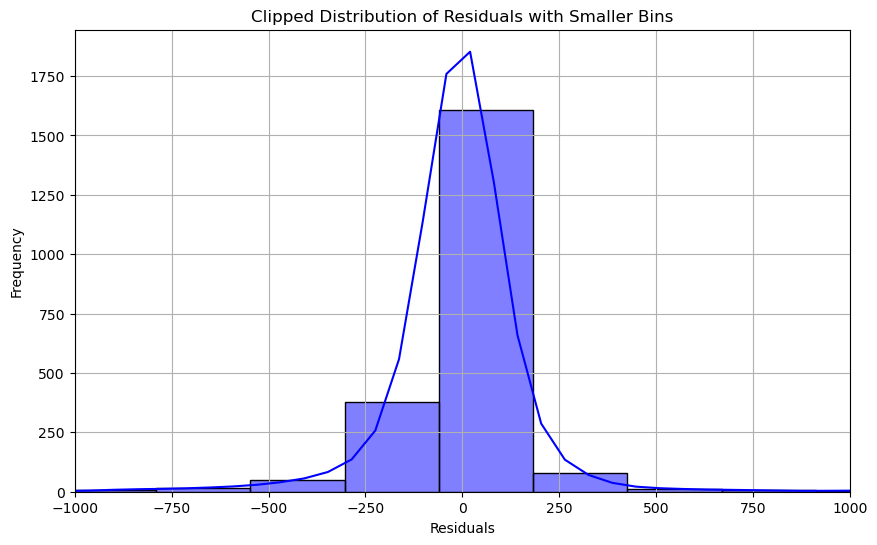

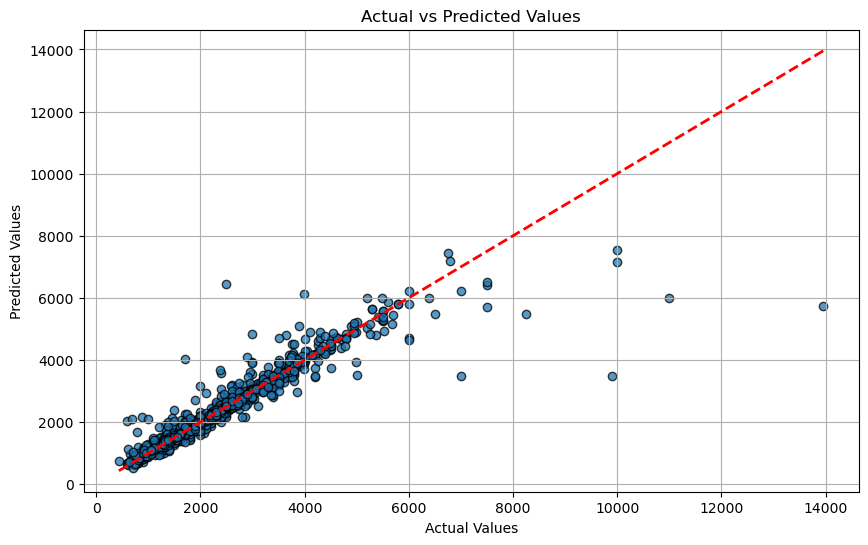

Mean Absolute Error (Tuned): 111.23833362570616
Median Absolute Error (Tuned): 43.67236328125
R-squared (Tuned): 0.8877702954443583


,Actual,Predicted
2773,1995.0,1963.335083
12427,1700.0,1816.542480
4606,1850.0,1910.626587
12386,1200.0,1175.312988
5807,1490.0,1497.212280
11160,1750.0,1630.653809
15321,1980.0,1947.649292
1093,1995.0,1997.176147
7196,2900.0,2842.850098
338,3850.0,3932.869873


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Predict on the test set using the best model
y_pred_tuned = best_model.predict(X_test_selected)

# Calculate residuals
residuals = y_test - y_pred_tuned

# 1. Residuals Plot: Plotting residuals against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned, residuals, alpha=0.75, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Residuals vs Fitted values")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 2. QQ Plot: Checking if residuals follow a normal distribution
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

# 3. Distribution of residuals: Checking the distribution of residuals with smaller bins and clipped range
plt.figure(figsize=(10, 6))

# Use more bins (e.g., 50) for smaller bin size and clip the x-axis range
sns.histplot(residuals, kde=True, bins=50, color='blue')

# Clip the distribution by setting the x-axis limits
plt.xlim(-1000, 1000)  # Adjust these limits based on the range of your residuals

plt.title("Clipped Distribution of Residuals with Smaller Bins")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.75, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# 5. Evaluation metrics
mse_tuned = mean_absolute_error(y_test, y_pred_tuned)
medae_tuned = median_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Mean Absolute Error (Tuned): {mse_tuned}")
print(f"Median Absolute Error (Tuned): {medae_tuned}")
print(f"R-squared (Tuned): {r2_tuned}")

# 6. Display the first few actual vs predicted rent values after fine-tuning
predictions_tuned = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tuned})
display(predictions_tuned.head(10))
